In [18]:
### create a heatmap of the single neuron responses to the 4 animal categories broken down per area

import numpy as np
import os
import matplotlib.pyplot as plt
import helperFunc
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
from statsmodels.stats.multitest import multipletests

# calculate z-scored time warped data taking the baseline as the first 10 timepoints
# calculate selectivity scores for each animal per neuron
# sort the neurons into 'selective' versus 'non-selective' based on the selectivity scores
# plot data per area showing the sensory period to show the baseline and onset of activity (timepoints 10-18)

cwd = Path.cwd()

savepath = cwd / 'Figure3CDEF/'
savepath.mkdir(parents=True, exist_ok=True)

# parameters
areas = ['LA', 'BLA', 'PIR']
savename = 'experiment1_earlytrials'

#load masterlist and significance
masterlist_initial = np.loadtxt(cwd / 'experiment1_alltaskneurons_taskspecificity.csv', delimiter=',', dtype=str)
pvaluealltrials = np.load(cwd / 'data_timewarped/responsiveneurons_earlytrials/trials_early_responsivesensory.npy')
pvaluecatchtrials = np.load(cwd / 'data_timewarped/responsiveneurons_earlytrials/catchtrials_responsivesensory.npy')
sig = np.where(np.count_nonzero(np.hstack((pvaluealltrials, pvaluecatchtrials)), axis=1) > 0)[0]




C:\Users\Cristina\AppData\Local\Temp\ipykernel_48008\3183757074.py:19: RuntimeWarning: divide by zero encountered in divide
  fouranimalzscore[i, :, :] = (ii-basemean)/basestd
C:\Users\Cristina\AppData\Local\Temp\ipykernel_48008\3183757074.py:19: RuntimeWarning: invalid value encountered in divide
  fouranimalzscore[i, :, :] = (ii-basemean)/basestd


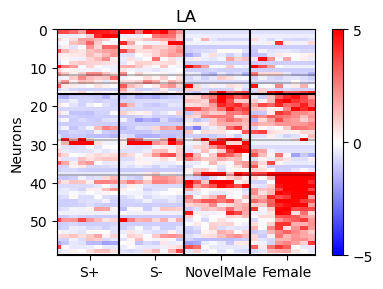

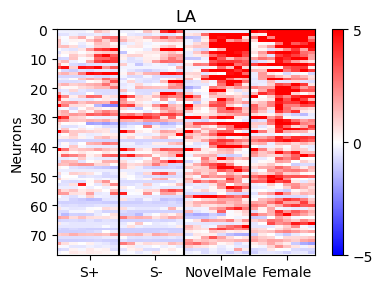

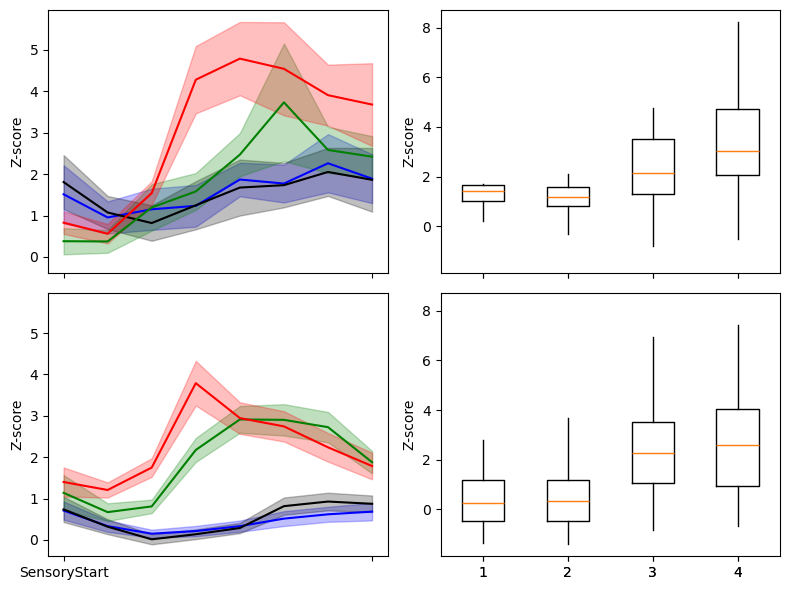

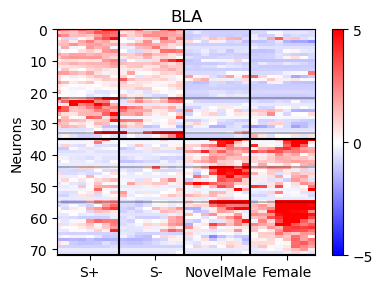

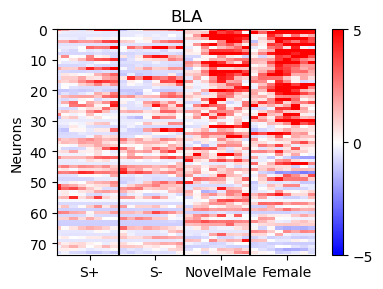

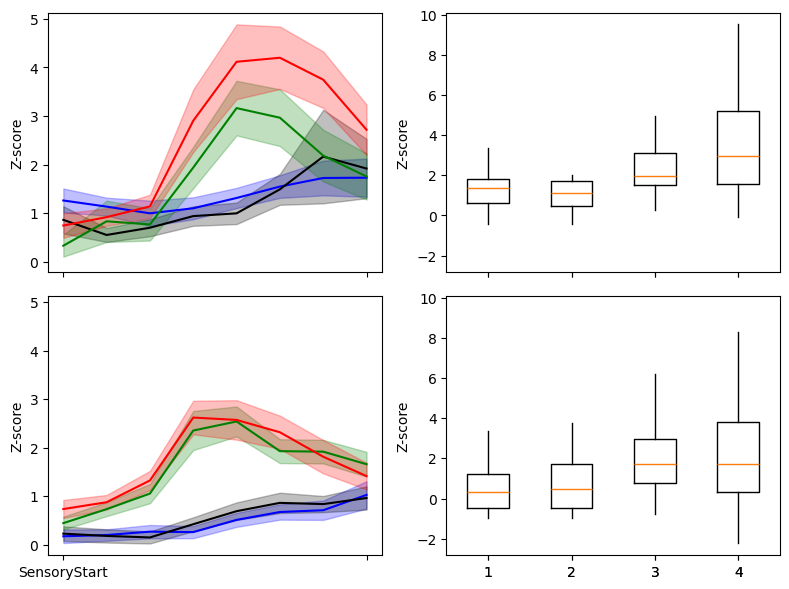

C:\Users\Cristina\AppData\Local\Temp\ipykernel_48008\3183757074.py:19: RuntimeWarning: divide by zero encountered in divide
  fouranimalzscore[i, :, :] = (ii-basemean)/basestd
C:\Users\Cristina\AppData\Local\Temp\ipykernel_48008\3183757074.py:19: RuntimeWarning: invalid value encountered in divide
  fouranimalzscore[i, :, :] = (ii-basemean)/basestd


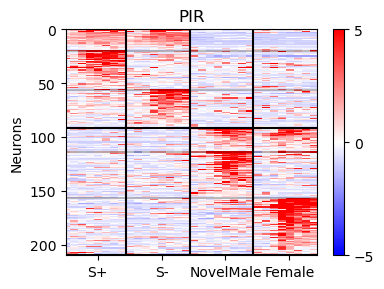

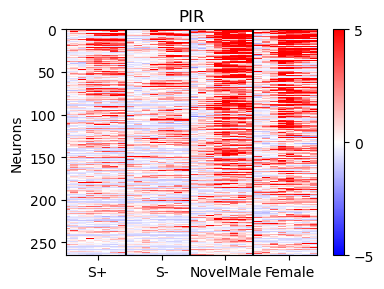

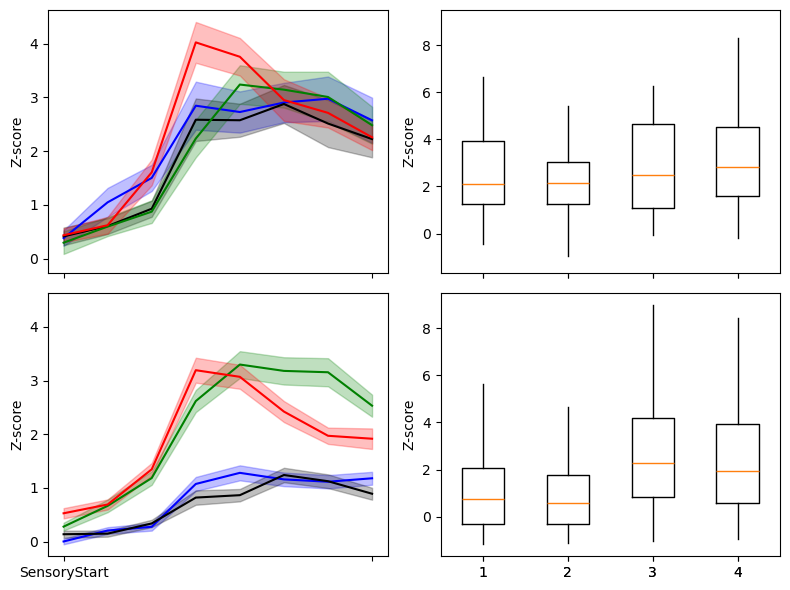

In [19]:
for area in areas:
    #limit analysis to only neurons in a specific area, and only ones that are responsive during sensory period
    
    idxtouse = np.where((masterlist_initial[:,2] == area))[0]
    idxtouse = np.intersect1d(idxtouse, sig)
    masterlist = masterlist_initial[idxtouse, :]

    # load the data from task and non-task animals and restrict to only neurons from specific area
    alltrials = np.load(cwd / 'data_timewarped/trials_early.npy')*10
    catchtrials = np.load(cwd / 'data_timewarped/catchtrials.npy')*10
    fouranimal = np.dstack((alltrials, catchtrials))
    fouranimal = fouranimal[idxtouse, :, :]
    fouranimalzscore = np.zeros((fouranimal.shape))

    # calculate a common baseline and zscore firing activity to that to compare across 4 conspecifics
    for i, ii in enumerate(fouranimal):
        basemean = np.mean(ii[:10, :])
        basestd = np.std(ii[:10, :])
        fouranimalzscore[i, :, :] = (ii-basemean)/basestd

    # smooth every row of the z-scored data
    fouranimalzscore = gaussian_filter1d(fouranimalzscore, 0.5, axis=1)

    # take sensory period (t10-18) for plotting and the peak of sensory activity to sort neurons
    sensoryzscore = fouranimalzscore[:, 10:18, :]
    maxsensoryzscore = np.mean(sensoryzscore[:,3:7,:], axis=1)

    # masterlist general neurons are coded 1, selective are -1 and nonresponsive are 0
    generalidx = np.where((masterlist[:,-2] == '1'))[0]
    selectiveidx = np.where((masterlist[:,-2] == '-1'))[0]
    nonresponsiveidx = np.where((masterlist[:,-2] == '0'))[0]

    """sort all general selectivity neurons by max firing"""
    # sort all general neurons from highest firing to lowest firing
    generalheatmap = sensoryzscore[generalidx, :, :]
    generalmaxscore = maxsensoryzscore[generalidx, :]
    sortorder = np.flip(np.argsort(np.mean(generalmaxscore, axis=1)))
    generalheatmap = generalheatmap[sortorder, :]

    # sort all task/non-task selective units from task selective, rewarded, unrewarded, non-taskselective, novel male, female
    #almost there, but need to separate out neurons that respond to both TASK animals and both NON-TASK animals to clean up sorting for LA and BLA

    """sort selective units by category (task selective, only S+ selective, only S- selective, non-task selective, only NM selective, only F selective"""
    """and then sort by max firing"""
    rewardedselectivity = maxsensoryzscore[:, 0] - np.mean(maxsensoryzscore[:, [1, 2, 3]], axis=1)
    unrewardedselectivity = maxsensoryzscore[:, 1] - np.mean(maxsensoryzscore[:, [0, 2, 3]], axis=1)
    novelmaleselectivity = maxsensoryzscore[:, 2] - np.mean(maxsensoryzscore[:, [0, 1, 3]], axis=1)
    femaleselectivity = maxsensoryzscore[:, 3] - np.mean(maxsensoryzscore[:, [0, 1, 2]], axis=1)
    selectivityscores = np.vstack((rewardedselectivity, unrewardedselectivity, novelmaleselectivity, femaleselectivity)).T

    selectiveheatmap = sensoryzscore[selectiveidx, :, :]
    selectivemaxscore = maxsensoryzscore[selectiveidx, :]
    selectivityscores = selectivityscores[selectiveidx, :]
    maxanimal = np.argmax(selectivityscores, axis=1)

    # use selectivity scores to break neurons into task and non-task categories
    taskidx = np.where(maxanimal < 2)[0]
    nontaskidx = np.where(maxanimal >= 2)[0]
    taskselective = selectiveheatmap[taskidx,:,:]
    nontaskselective = selectiveheatmap[nontaskidx,:,:]

    # sort each of these categories into neurons that fire for both animals vs. only one animal
    taskscores = selectivemaxscore[taskidx, :]
    taskscoresstd = np.ravel(np.std(taskscores[:,:], axis=1))
    taskanimaldiff = np.abs(np.ravel(np.diff(taskscores[:,:2], axis=1)))
    # assign to categories based on the strenght of the response to S+ or S-
    rewardedidx = np.where((taskanimaldiff > taskscoresstd) & (taskscores[:,0] > taskscores[:,1]))[0]
    unrewardedidx = np.where((taskanimaldiff > taskscoresstd) & (taskscores[:,0] < taskscores[:,1]))[0]
    multitaskanimalidx = np.where(taskanimaldiff <= taskscoresstd)[0]

    rewarded = taskselective[rewardedidx, :, :]
    sortorder = np.flip(np.argsort(taskscores[rewardedidx, 0]))
    rewarded = rewarded[sortorder, :]
    unrewarded = taskselective[unrewardedidx, :, :]
    sortorder = np.flip(np.argsort(taskscores[unrewardedidx, 1]))
    unrewarded = unrewarded[sortorder, :]
    multitaskselective = taskselective[multitaskanimalidx, :, :]
    sortorder = np.flip(np.argsort(np.mean(taskscores[multitaskanimalidx, :2], axis=1)))
    multitaskselective = multitaskselective[sortorder, :]

    ## repeat with the non-task animal scores
    nontaskscores = selectivemaxscore[nontaskidx, :]
    nontaskscoresstd = np.ravel(np.std(nontaskscores[:,:], axis=1))
    nontaskanimaldiff = np.abs(np.ravel(np.diff(nontaskscores[:,2:], axis=1)))
    novelmaleidx = np.where((nontaskanimaldiff > nontaskscoresstd) & (nontaskscores[:,2] > nontaskscores[:,3]))[0]
    femaleidx = np.where((nontaskanimaldiff > nontaskscoresstd) & (nontaskscores[:,2] < nontaskscores[:,3]))[0]
    multinontaskanimalidx = np.where(nontaskanimaldiff <= nontaskscoresstd)[0]

    novelmale = nontaskselective[novelmaleidx, :, :]
    sortorder = np.flip(np.argsort(nontaskscores[novelmaleidx, 2]))
    novelmale = novelmale[sortorder, :]
    female = nontaskselective[femaleidx, :, :]
    sortorder = np.flip(np.argsort(nontaskscores[femaleidx, 3]))
    female = female[sortorder, :]
    multinontaskselective = nontaskselective[multinontaskanimalidx, :, :]
    sortorder = np.flip(np.argsort(np.mean(nontaskscores[multinontaskanimalidx, 2:], axis=1)))
    multinontaskselective = multinontaskselective[sortorder, :]

    ## pool all sorted selective data together for heatmap
    allsorted = np.vstack((multitaskselective, rewarded, unrewarded, multinontaskselective, novelmale, female))
    plotheatmap = np.hstack((allsorted[:,:,0], allsorted[:,:,1], allsorted[:,:,2], allsorted[:,:,3]))

    """plot selective heatmap for area"""
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    cb = ax.imshow(plotheatmap, aspect='auto', interpolation='None', cmap='bwr', vmin=-5, vmax=5)
    ax.set_xticks((4, 12, 20, 28))
    ax.set_xticklabels(('S+', 'S-', 'NovelMale', 'Female'))
    ax.vlines((7.5, 15.5, 23.5), 0, plotheatmap.shape[0], colors='k')
    ax.set_ylim(plotheatmap.shape[0], 0)

    taskselectivenum = multitaskselective.shape[0] + rewarded.shape[0] + unrewarded.shape[0]
    nontaskselectivenum = multinontaskselective.shape[0] + novelmale.shape[0] + female.shape[0]
    ax.hlines((taskselectivenum, taskselectivenum+nontaskselectivenum), 0, plotheatmap.shape[1]-0.5, colors='k')
    ax.set_xlim(0, plotheatmap.shape[1]-0.5)
    ax.hlines((multitaskselective.shape[0], multitaskselective.shape[0]+rewarded.shape[0]), 0, plotheatmap.shape[0], colors='k', alpha=0.25)
    ax.hlines((taskselectivenum + multinontaskselective.shape[0], taskselectivenum + multinontaskselective.shape[0] + novelmale.shape[0]), 0, plotheatmap.shape[0], colors='k', alpha=0.25)

    ax.set_ylabel('Neurons')
    ax.set_title(area)
    colorbar = plt.colorbar(cb)
    colorbar.set_ticks([-5, 0, 5])
    plt.tight_layout()
    plt.show()
    fig.savefig(savepath / f"{area}_{savename}_heatmap_selective.png", dpi=300)

    """plot general heatmap for area"""
    plotgeneral = np.hstack((generalheatmap[:,:,0], generalheatmap[:,:,1], generalheatmap[:,:,2], generalheatmap[:,:,3]))

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    cb = ax.imshow(plotgeneral, aspect='auto', interpolation='None', cmap='bwr', vmin=-5, vmax=5)
    ax.set_xticks((4, 12, 20, 28))
    ax.set_xticklabels(('S+', 'S-', 'NovelMale', 'Female'))
    ax.vlines((7.5, 15.5, 23.5), 0, plotgeneral.shape[0], colors='k')
    ax.set_ylim(plotgeneral.shape[0], 0)
    ax.set_xlim(0, plotgeneral.shape[1] - 0.5)
    ax.set_ylabel('Neurons')
    ax.set_title(area)
    colorbar = plt.colorbar(cb)
    colorbar.set_ticks([-5, 0, 5])
    plt.tight_layout()
    plt.show()
    fig.savefig(savepath / f"{area}_{savename}_heatmap_selective.png", dpi=300)

    """plot mean responses for selective and general neurons with mean+-SEM and quantify. 4 subplots per area"""

    plt.close()
    ##subplot1 - selective mean +- SEM
    fig, ax = plt.subplots(2, 2, figsize = (8, 6), sharex='col', sharey='col')
    ax[0,0].plot(np.mean(np.vstack((multitaskselective[:,:,0], rewarded[:, :, 0])), axis=0), color='blue', label='S+ selective')
    ax[0,0].plot(np.mean(np.vstack((multitaskselective[:,:,1], unrewarded[:, :, 1])), axis=0), color='k', label='S- selective')
    ax[0,0].plot(np.mean(np.vstack((multinontaskselective[:,:,2], novelmale[:, :, 2])), axis=0), color='green', label='novelmale selective')
    ax[0,0].plot(np.mean(np.vstack((multinontaskselective[:,:,3], female[:, :, 3])), axis=0), color='red', label='female selective')

    ax[0,0].fill_between(np.arange(0, np.vstack((multitaskselective[:,:,0], rewarded[:, :, 0])).shape[1]),
                    np.mean(np.vstack((multitaskselective[:,:,0], rewarded[:, :, 0])), axis=0) - stats.sem(np.vstack((multitaskselective[:,:,0], rewarded[:, :, 0])), axis=0),
                    np.mean(np.vstack((multitaskselective[:,:,0], rewarded[:, :, 0])), axis=0) + stats.sem(np.vstack((multitaskselective[:,:,0], rewarded[:, :, 0])), axis=0), color='blue', alpha=0.25)
    ax[0,0].fill_between(np.arange(0, np.vstack((multitaskselective[:,:,1], unrewarded[:, :, 1])).shape[1]),
                    np.mean(np.vstack((multitaskselective[:,:,1], unrewarded[:, :, 1])), axis=0) - stats.sem(np.vstack((multitaskselective[:,:,1], unrewarded[:, :, 1])), axis=0),
                    np.mean(np.vstack((multitaskselective[:,:,1], unrewarded[:, :, 1])), axis=0) + stats.sem(np.vstack((multitaskselective[:,:,1], unrewarded[:, :, 1])), axis=0), color='k', alpha=0.25)
    ax[0,0].fill_between(np.arange(0, np.vstack((multinontaskselective[:,:,2], novelmale[:, :, 2])).shape[1]),
                    np.mean(np.vstack((multinontaskselective[:,:,2], novelmale[:, :, 2])), axis=0) - stats.sem(np.vstack((multinontaskselective[:,:,2], novelmale[:, :, 2])), axis=0),
                    np.mean(np.vstack((multinontaskselective[:,:,2], novelmale[:, :, 2])), axis=0) + stats.sem(np.vstack((multinontaskselective[:,:,2], novelmale[:, :, 2])), axis=0), color='green', alpha=0.25)
    ax[0,0].fill_between(np.arange(0, np.vstack((multinontaskselective[:,:,3], female[:, :, 3])).shape[1]),
                    np.mean(np.vstack((multinontaskselective[:,:,3], female[:, :, 3])), axis=0) - stats.sem(np.vstack((multinontaskselective[:,:,3], female[:, :, 3])), axis=0),
                    np.mean(np.vstack((multinontaskselective[:,:,3], female[:, :, 3])), axis=0) + stats.sem(np.vstack((multinontaskselective[:,:,3], female[:, :, 3])), axis=0), color='red', alpha=0.25)

    ax[0,0].set_ylabel('Z-score')
    ax[0,0].set_xticks([0,7])
    ax[0,0].set_xticklabels(['SensoryStart', ' '])

    if area == 'LA':
        generalheatmap = np.delete(generalheatmap, np.unique(np.where(np.isnan(generalheatmap))[0])[0], axis=0)
    if area == 'ENDO':
        generalheatmap = np.delete(generalheatmap, np.unique(np.where(np.isnan(generalheatmap))[0])[0], axis=0)

    # subplot2 - general mean +- SEM
    ax[1,0].plot(np.nanmean(generalheatmap[:,:,0], axis=0), color='blue')
    ax[1,0].plot(np.nanmean(generalheatmap[:,:,1], axis=0), color='k')
    ax[1,0].plot(np.nanmean(generalheatmap[:,:,2], axis=0), color='green')
    ax[1,0].plot(np.nanmean(generalheatmap[:,:,3], axis=0), color='red')
    ax[1,0].fill_between(np.arange(0, generalheatmap.shape[1]), np.nanmean(generalheatmap[:,:,0], axis=0) - stats.sem(generalheatmap[:,:,0], axis=0),
                    np.nanmean(generalheatmap[:,:,0], axis=0) + stats.sem(generalheatmap[:,:,0], axis=0), color='blue', alpha=0.25)
    ax[1,0].fill_between(np.arange(0, generalheatmap.shape[1]), np.nanmean(generalheatmap[:,:,1], axis=0) - stats.sem(generalheatmap[:,:,1], axis=0),
                    np.nanmean(generalheatmap[:,:,1], axis=0) + stats.sem(generalheatmap[:,:,1], axis=0), color='k', alpha=0.25)
    ax[1,0].fill_between(np.arange(0, generalheatmap.shape[1]), np.nanmean(generalheatmap[:,:,2], axis=0) - stats.sem(generalheatmap[:,:,2], axis=0),
                    np.nanmean(generalheatmap[:,:,2], axis=0) + stats.sem(generalheatmap[:,:,2], axis=0), color='green', alpha=0.25)
    ax[1,0].fill_between(np.arange(0, generalheatmap.shape[1]), np.nanmean(generalheatmap[:,:,3], axis=0) - stats.sem(generalheatmap[:,:,3], axis=0),
                    np.nanmean(generalheatmap[:,:,3], axis=0) + stats.sem(generalheatmap[:,:,3], axis=0), color='red', alpha=0.25)

    ax[1,0].set_ylabel('Z-score')
    ax[1,0].set_xticks([0,7])
    ax[1,0].set_xticklabels(['SensoryStart', ' '])


    rewardedresponse = np.mean(np.vstack((multitaskselective[:, 3:7, 0], rewarded[:, 3:7, 0])), axis=1)
    unrewardedresponse = np.mean(np.vstack((multitaskselective[:, 3:7, 1], unrewarded[:, 3:7, 1])), axis=1)
    novelmaleresponse = np.mean(np.vstack((multinontaskselective[:, 3:7, 2], novelmale[:, 3:7, 2])), axis=1)
    femaleresponse = np.mean(np.vstack((multinontaskselective[:, 3:7, 3], female[:, 3:7, 3])), axis=1)


    # subplot 3 - quantification selective responses
    ax[0,1].boxplot([rewardedresponse, unrewardedresponse, novelmaleresponse, femaleresponse], showfliers=False, showcaps=False, widths=0.5)
    ax[0,1].set_ylabel('Z-score')
    
    data = pd.DataFrame({
        'response': np.concatenate([rewardedresponse, unrewardedresponse, novelmaleresponse, femaleresponse]),
        'group': ['S+'] * len(rewardedresponse) + ['S-'] * len(unrewardedresponse) +
                 ['NM'] * len(novelmaleresponse) + ['F'] * len(femaleresponse)
    })
    data_groups = [rewardedresponse, unrewardedresponse, novelmaleresponse, femaleresponse]
    resultssave = []
    stat, p = stats.kruskal(*data_groups)
    resultssave.append(f"Kruskal-Wallis Test: H = {stat}, p = {p}")

    # Mann-Whitney U test for pairwise comparisons
    pairwise_results = []
    for i in range(len(data_groups)):
        for j in range(i + 1, len(data_groups)):
            stat, p = stats.mannwhitneyu(data_groups[i], data_groups[j])
            pairwise_results.append({'Group1': i + 1, 'Group2': j + 1, 'U-Statistic': stat, 'P-Value': p})
            resultssave.append(f"Group {i + 1} vs Group {j + 1}: U = {stat}, p = {p}")
    pairwise_df = pd.DataFrame(pairwise_results)
    # Apply Bonferroni correction
    corrected_p_values = multipletests(pairwise_df['P-Value'], method='bonferroni')[1]
    pairwise_df['Corrected P-Value'] = corrected_p_values
    resultssave.append(pairwise_df.to_string(index=False))
    np.savetxt(savepath / f"{area}_{savename}_results_specific.txt", resultssave, fmt='%s', delimiter='\n')

    # subplot4 - boxplot and quantification for general neurons
    generalresponse = np.mean(generalheatmap[:, 3:7, :], axis=1)
    ax[1,1].boxplot([generalresponse[:,0], generalresponse[:,1], generalresponse[:,2], generalresponse[:,3]], showfliers=False, showcaps=False, widths=0.5)
    ax[1,1].set_ylabel('Z-score')
    plt.tight_layout()
    plt.show()
    fig.savefig(savepath / f"{area}_{savename}_quantification.png")

    # run stats
    data_groups_general = [generalresponse[:,0], generalresponse[:,1], generalresponse[:,2], generalresponse[:,3]]
    # Kruskall wallis
    stat, p = stats.kruskal(*data_groups_general)
    resultssave2 = []
    resultssave2.append(f"Kruskal-Wallis Test: H = {stat}, p = {p}")
    pairwise_results2 = []
    for i in range(len(data_groups_general)):
        for j in range(i + 1, len(data_groups_general)):
            stat, p = stats.mannwhitneyu(data_groups_general[i], data_groups_general[j])
            pairwise_results2.append({'Group1': i + 1, 'Group2': j + 1, 'U-Statistic': stat, 'P-Value': p})
            resultssave2.append(f"Group {i + 1} vs Group {j + 1}: U = {stat}, p = {p}")
    pairwise_df2 = pd.DataFrame(pairwise_results2)
    # Apply Bonferroni correction
    corrected_p_values2 = multipletests(pairwise_df2['P-Value'], method='bonferroni')[1]
    pairwise_df2['Corrected P-Value'] = corrected_p_values2
    resultssave2.append(pairwise_df2.to_string(index=False))
    # save results
    results2 = np.array(resultssave2)

    np.savetxt(savepath / f"{area}_{savename}_results_general.txt", results2, fmt='%s', delimiter='\n')


